In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

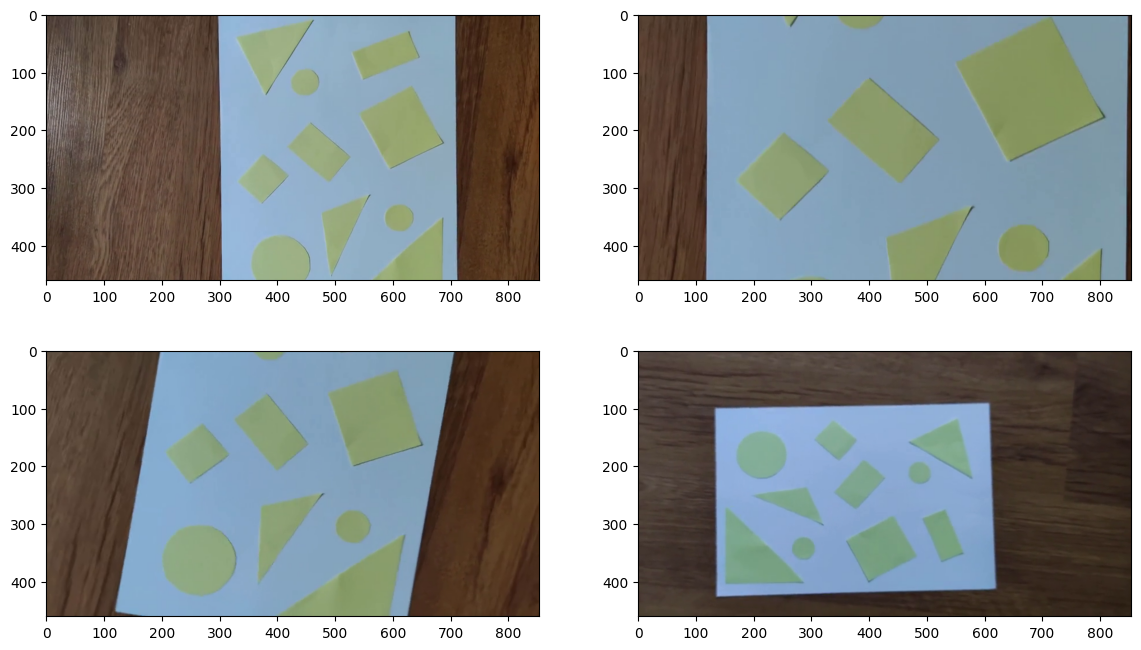

In [7]:
cap = cv2.VideoCapture('figures.mp4')

# capture some random frames
frames = 0
random_frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames += 1
    # every 100th frame
    if frames % 100 == 0:
        random_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()
cv2.destroyAllWindows()

# plot some of random frames
f, axarr = plt.subplots(2, 2, figsize=(14, 8))
axarr[0][0].imshow(random_frames[0])
axarr[0][1].imshow(random_frames[2])
axarr[1][0].imshow(random_frames[4])
axarr[1][1].imshow(random_frames[5])

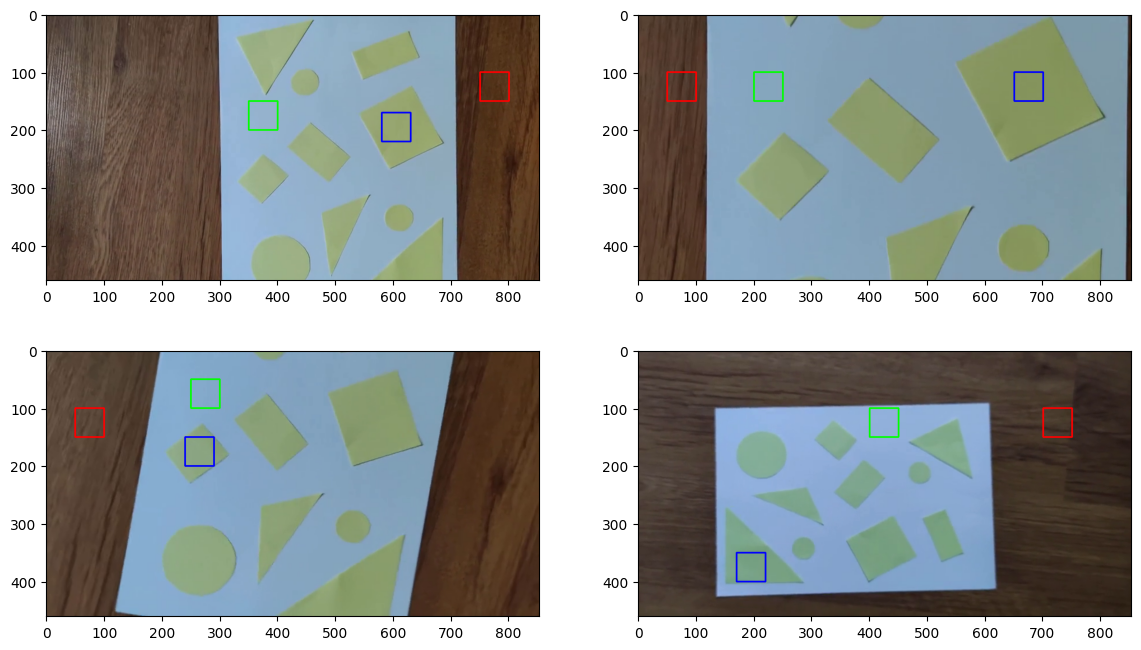

In [25]:
# here i will store samples of colors
desk = np.zeros_like(random_frames[0][0:100, 0:100])
paper = desk.copy()
shape = desk.copy()

def pick_color(frame, desk_w, desk_h, paper_w, paper_h, shape_w, shape_h):
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    # show which sample i pick
    cv2.rectangle(frame, (desk_w, desk_h),   (desk_w  + 50, desk_h  + 50), (255, 0, 0), 2) # desk (red)
    cv2.rectangle(frame, (paper_w, paper_h), (paper_w + 50, paper_h + 50), (0, 255, 0), 2) # paper (green)
    cv2.rectangle(frame, (shape_w, shape_h), (shape_w + 50, shape_h + 50), (0, 0, 255), 2) # shape (blue)
    # pick 50x50 samples
    return frame, hsv[desk_h:desk_h+50, desk_w:desk_w+50],\
                  hsv[paper_h:paper_h+50, paper_w:paper_w+50],\
                  hsv[shape_h:shape_h+50, shape_w:shape_w+50]

f, axarr = plt.subplots(2, 2, figsize=(14, 8))
frame, desk[0:50, 0:50], paper[0:50, 0:50], shape[0:50, 0:50] = pick_color(random_frames[0].copy(), 750, 100, 350, 150, 580, 170)
axarr[0][0].imshow(frame)
frame, desk[0:50, 50:100], paper[0:50, 50:100], shape[0:50, 50:100] = pick_color(random_frames[2].copy(), 50, 100, 200, 100, 650, 100)
axarr[0][1].imshow(frame)
frame, desk[50:100, 0:50], paper[50:100, 0:50], shape[50:100, 0:50] = pick_color(random_frames[4].copy(), 50, 100, 250, 50, 240, 150)
axarr[1][0].imshow(frame)
frame, desk[50:100, 50:100], paper[50:100, 50:100], shape[50:100, 50:100] = pick_color(random_frames[5].copy(), 700, 100, 400, 100, 170, 350)
axarr[1][1].imshow(frame)

(array([[ 12.502 ],
       [120.5766],
       [ 80.2179]]), array([[ 1.86986524],
       [33.05296556],
       [ 9.64084123]]))
(array([[104.4372],
       [ 80.4572],
       [204.1341]]), array([[ 1.80256932],
       [ 7.6110031 ],
       [10.65475092]]))
(array([[ 49.4724],
       [ 75.039 ],
       [159.7737]]), array([[13.04860292],
       [15.71719692],
       [ 7.17628653]]))


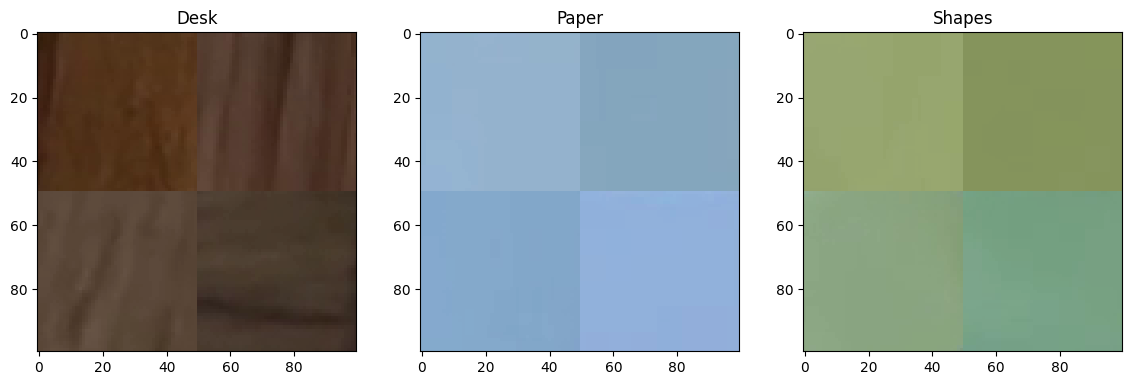

In [24]:
# show mean and std of sample colors
f, axarr = plt.subplots(1,3, figsize=(14, 8))

axarr[0].set_title('Desk')
axarr[0].imshow(cv2.cvtColor(desk,  cv2.COLOR_HSV2RGB))
print(cv2.meanStdDev(desk))

axarr[1].set_title('Paper')
axarr[1].imshow(cv2.cvtColor(paper, cv2.COLOR_HSV2RGB))
print(cv2.meanStdDev(paper))

axarr[2].set_title('Shapes')
axarr[2].imshow(cv2.cvtColor(shape, cv2.COLOR_HSV2RGB))
print(cv2.meanStdDev(shape))

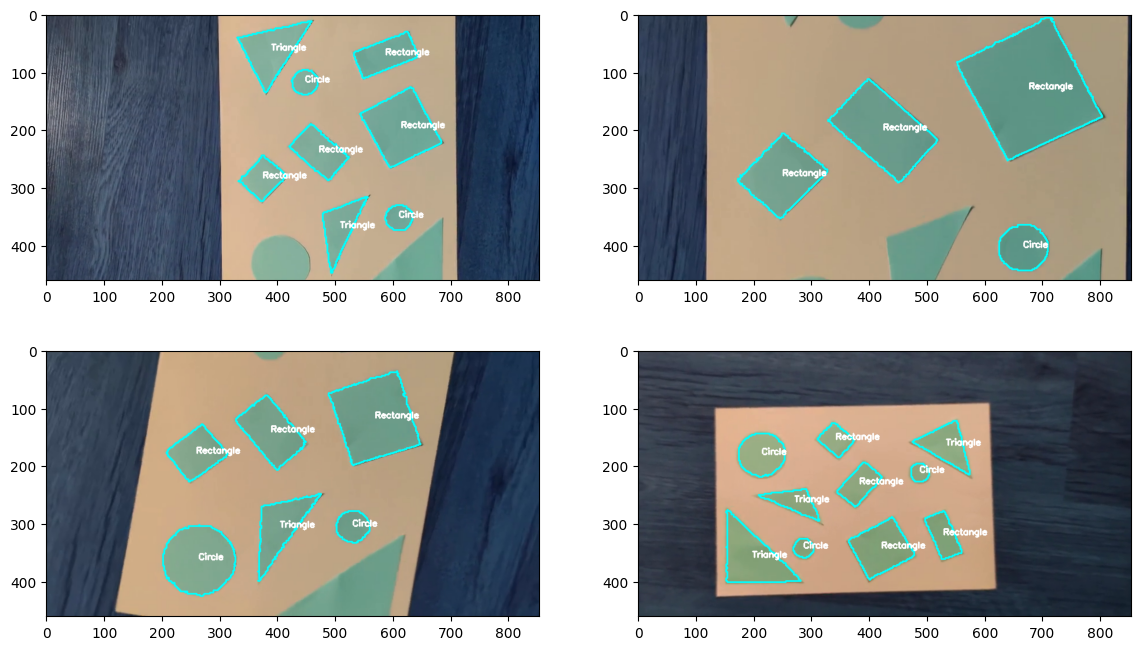

In [22]:
def classify_shape(contour):
    # get number of angles (curves)
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.03 * peri, True)
    num_sides = len(approx)

    if num_sides == 3:
        return "Triangle"
    elif num_sides == 4:
        return "Rectangle"
    elif num_sides > 4:
        return "Circle"
    else:
        return "Unknown"

def process(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([30, 40, 140]) 
    upper_yellow = np.array([80, 255, 255]) 
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow) 
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_y, max_x = frame.shape[:2]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # shape does not touch border (fully visible)
        if x > 1 and y > 1 and x+w < max_x and y+h < max_y and cv2.contourArea(c) > 500:
            cv2.drawContours(frame, [c], -1, (0, 255, 255), 2)
            M = cv2.moments(c)
            if (M["m00"]) != 0:
                # shape center
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # put text
                shape_name = classify_shape(c)
                cv2.putText(frame, shape_name, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return frame

# test on my random frames
f, axarr = plt.subplots(2, 2, figsize=(14, 8))
axarr[0][0].imshow(process(cv2.cvtColor(random_frames[0], cv2.COLOR_RGB2BGR)))
axarr[0][1].imshow(process(cv2.cvtColor(random_frames[2], cv2.COLOR_RGB2BGR)))
axarr[1][0].imshow(process(cv2.cvtColor(random_frames[4], cv2.COLOR_RGB2BGR)))
axarr[1][1].imshow(process(cv2.cvtColor(random_frames[5], cv2.COLOR_RGB2BGR)))

In [21]:
input = cv2.VideoCapture('figures.mp4')

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # codec
fps = int(input.get(cv2.CAP_PROP_FPS))
w   = int(input.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(input.get(cv2.CAP_PROP_FRAME_HEIGHT))
output = cv2.VideoWriter('output.mp4', fourcc, fps, (w, h))

while True:
    ret, frame = input.read()
    if not ret:
        break

    output.write(process(frame))

    if cv2.waitKey(1) == ord('q'):
        break

input.release()
output.release()
cv2.destroyAllWindows()